In [296]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [491]:
events_raw_r = np.loadtxt(path + "data/MVSEC/events.txt")

In [492]:
events_raw = events_raw_r[:]

In [493]:
events_raw_t = np.zeros(events_raw.shape)
events_raw_t[:,0] = events_raw[:, 2] - events_raw[0, 2]
events_raw_t[:,1:] = events_raw[:, [0, 1, 3]]

In [494]:
events_ref = flt.filter_refract(events_raw_t, 0.05)
# events_ref = events_raw_t

In [495]:
events_ref[-1, 0] - events_ref[0, 0]

0.23269009590148926

In [496]:
start_time = events_ref[0, 0] + 0.1
duration = 0.5
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [497]:
# patch_center = (30, 90)
# patch_size = 20
# patch_center = (90, 90)
# patch_size = 180
shape = (260, 346)
# events = flt.filter_patch(events_t, patch_center, patch_size)
events = events_t

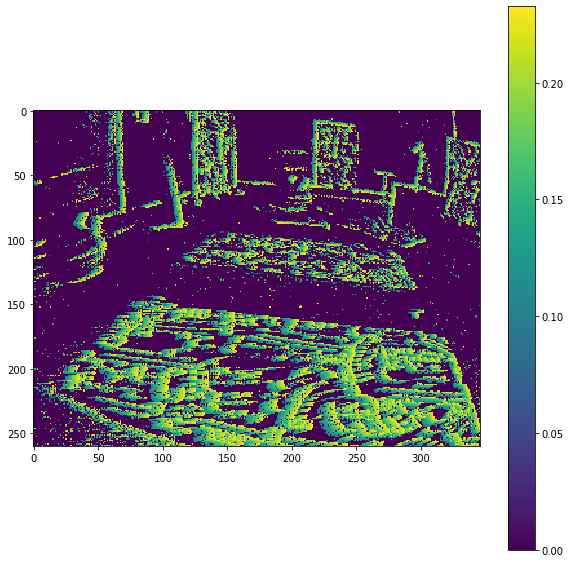

In [498]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events[:], shape, filter_polarity=True, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img, interpolation="none")
plt.colorbar(mappable=m)

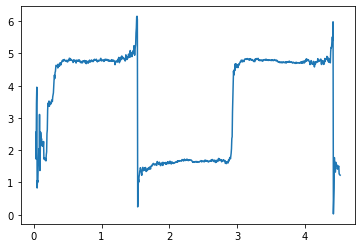

In [499]:
gt = np.loadtxt(path + "data/shapes_translation/groundtruth.txt", max_rows=900)
speed = np.array([gt[1:,1] - gt[:-1, 1], gt[1:,2] - gt[:-1, 2]]) / (gt[1:,0] - gt[:-1, 0])

speed_c_x = np.convolve(speed[0], np.ones(10, )) / 10
speed_c_y = np.convolve(speed[1], np.ones(10, )) / 10 

directions = np.arctan2(speed_c_y, speed_c_x)
# directions = np.arctan2(speed[1], speed[0])
directions = np.mod(directions, 2*np.pi)
#directions = np.convolve(directions, np.ones((30, ))) / 30
plt.plot(gt[:,0], directions[:gt[:,0].size])

In [537]:
last_time = np.full(shape, -1.0)
dist = 2
td_predictions = {}
predictions = {}
px_range_pred = 15
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
    if e[3] == 0:
        continue
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else -1.0)
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else -1.0)
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else -1.0)
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else -1.0)
    
    #get camera direction
#     id_direction = np.searchsorted(gt[:,0], e[0])
# #     print(id_direction)
#     direction = directions[id_direction] - np.pi
#     direction = np.mod(direction, 2*np.pi)
    direction = np.deg2rad(20)
#     print(np.rad2deg(direction))
    
#     if 0.0 <= direction < np.pi/2:
#         v_td = d_td
#         h_td = l_td
#     elif np.pi/2 <= direction < np.pi:
#         v_td = d_td
#         h_td = -r_td
#     elif np.pi <= direction < (3/2)*np.pi:
#         v_td = -u_td
#         h_td = -r_td
#     elif (3/2)*np.pi <= direction < 2*np.pi:
#         v_td = -u_td
#         h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

    
#     if np.isnan(v_td) or np.isnan(h_td):
#         continue

    t_lim = 0.01

    if u_td < 0.0:
        if d_td < 0.0:
            continue
        else:
            v_td = d_td
    else:
        if d_td >= 0:
            v_td = d_td if d_td >= u_td else -u_td
        else:
            v_td = -u_td
            
    if r_td < 0.0:
        if l_td < 0.0:
            continue
        else:
            h_td = l_td
    else:
        if l_td >= 0:
            h_td = l_td if l_td >= r_td else -r_td
        else:
            h_td = -r_td
        
    U[y, x] = h_td
    V[y, x] = v_td
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = direction - np.arctan2(v_td, h_td)
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    
#     U[y, x] = np.cos(direction) * time_difference
#     V[y, x] = np.sin(direction) * time_difference
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        std_pred = np.std(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 0.1:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.02 and len(td_predictions[y, x]) > 5:
            final_td[y, x] = mean_pred
            
    td_predictions[y, x] = []
    a = direction
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = int(x + np.cos(a)*i + np.sin(a)*k)
            y_p = int(y + np.sin(a)*i - np.cos(a)*k)
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|██████████████████████████████████████████████████████████████████████████| 47767/47767 [00:28<00:00, 1647.79it/s]


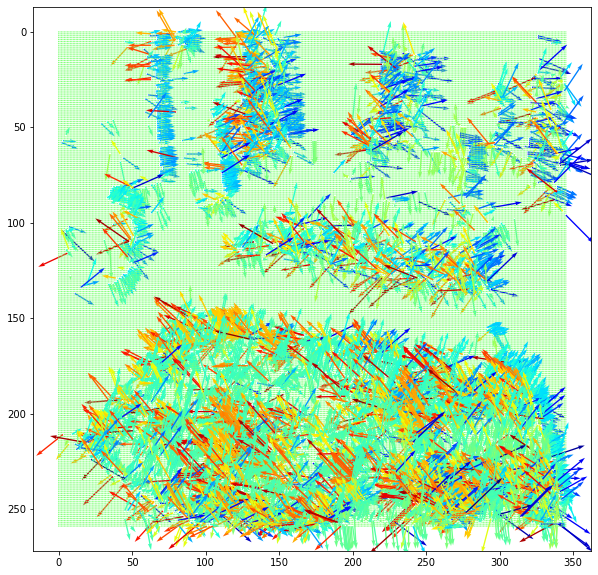

In [538]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, U, scale =2, cmap="jet_r")
plt.gca().invert_yaxis()

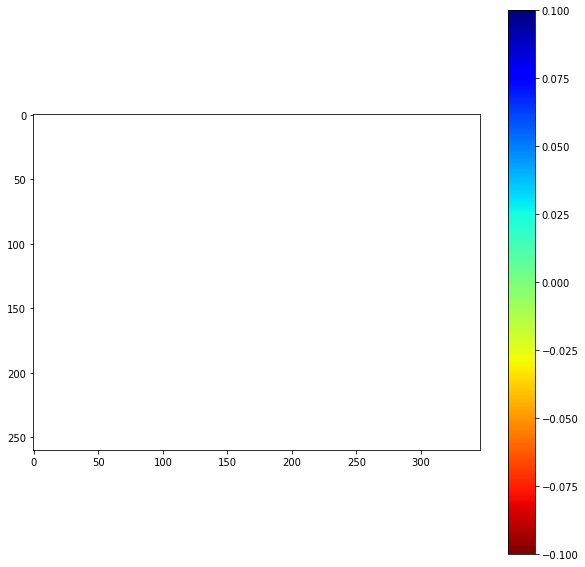

In [539]:
plt.figure(figsize=(10, 10))
#img_gray = plt.imread(path + "data/shapes_translation/images/frame_00000063.png")
final_td = np.abs(np.ma.masked_where(final_td == 0, final_td))
#plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td, cmap="jet_r", interpolation="none")
plt.colorbar(m)

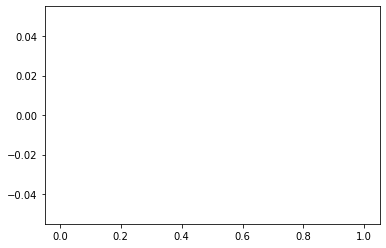

In [532]:
plt.hist(final_td.compressed(), 100);

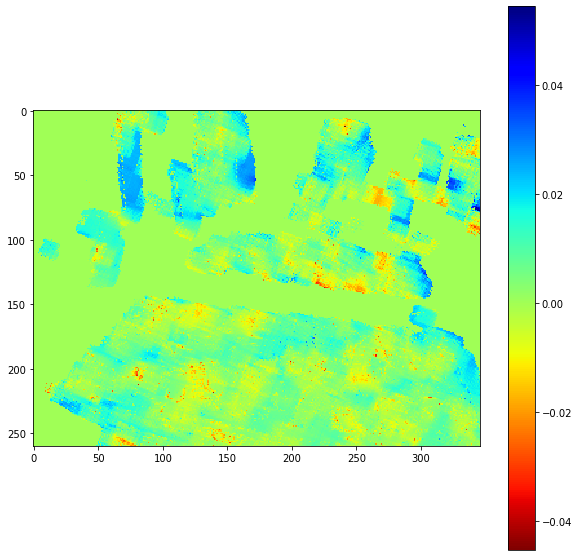

In [533]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 5)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [251]:
u = np.divide(1.0, final_td, where=final_td!=0.0)

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_22252/938763134.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u = np.divide(1.0, final_td, where=final_td!=0.0)


In [252]:
id_speed = np.searchsorted(gt[:,0], start_time+duration/2)
v = np.sqrt(np.square(speed[0, id_speed]) + np.square(speed[1, id_speed]))

In [253]:
f = 199.092366542

In [254]:
d = td.v2depth(u, v, f)

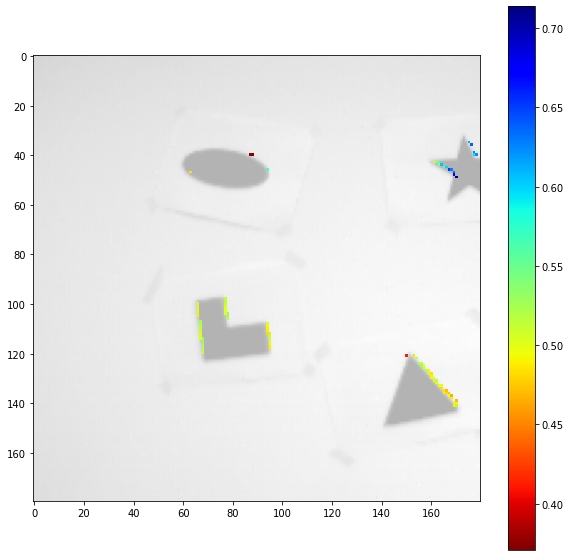

In [255]:
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [182]:
%matplotlib qt
vis.visualize3d(d)

In [183]:
points = vis._image2pointcloud(d)

calib = np.loadtxt(path + "/data/boxes_translation/calib.txt")
gt = np.loadtxt(path + "/data/boxes_translation/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

proj = td.project3d(points, calib, pose)

In [184]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r")
#ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [21]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

o3d.visualization.draw_geometries([pcd])

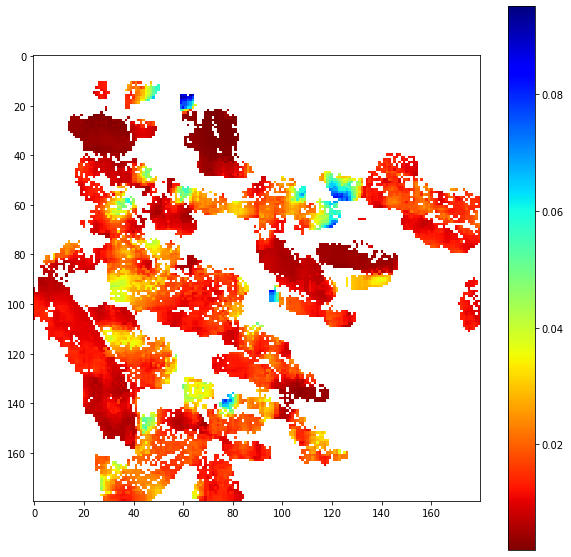

In [22]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 7)
img_m = np.abs(np.ma.masked_where(img==0, img))
plt.figure(figsize=(10, 10))
m = plt.imshow(img_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)

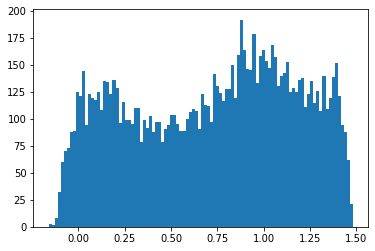

In [23]:
angles = np.array(angles)
plt.hist(angles, 100);

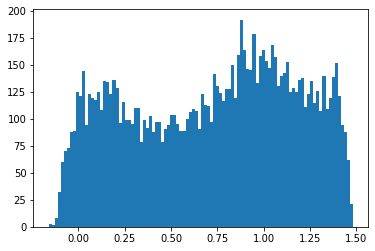

In [24]:
angles_u = np.unwrap(angles)
plt.hist(angles_u, 100);

In [25]:
x = 0
y = 0
a = np.pi / 6

u = 3
v = 1

x_p = x + np.cos(a)*u + np.sin(a)*v
y_p = y + np.sin(a)*u - np.cos(a)*v

In [26]:
print(x_p)
print(y_p)

3.098076211353316
0.6339745962155611


In [27]:
time_d = td.compute_time_difference(events, shape, check_polarity=True, polarity=1)

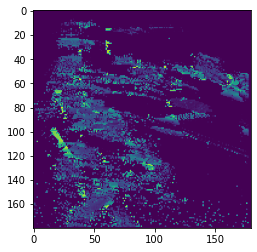

In [28]:
plt.imshow(time_d)

In [29]:
last_time = np.full(shape, -1.0)
dist = 2
td_predictions = {}
predictions = {}
px_range_pred = 7
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 0:
#         continue
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else float("Nan"))
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else float("Nan"))
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else float("Nan"))
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else float("Nan"))
    
    #get camera direction
    id_direction = np.searchsorted(gt[:,0], e[0])
    direction = directions[id_direction] - np.pi
    direction = np.mod(direction, 2*np.pi)
    
#     print(np.rad2deg(direction))
    
    if 0.0 <= direction < np.pi/2:
        v_td = d_td
        h_td = l_td
    elif np.pi/2 <= direction < np.pi:
        v_td = d_td
        h_td = -r_td
    elif np.pi <= direction < (3/2)*np.pi:
        v_td = -u_td
        h_td = -r_td
    elif (3/2)*np.pi <= direction < 2*np.pi:
        v_td = -u_td
        h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

    U[y, x] = h_td if not np.isnan(h_td) else 0
    V[y, x] = v_td if not np.isnan(v_td) else 0
    
    if np.isnan(v_td) or np.isnan(h_td):
        continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = direction - np.arctan2(v_td, h_td)
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    
    if (y, x) in td_predictions:
        mean_pred = np.mean(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 0.003:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            continue
        if np.abs(mean_pred - time_difference) > 0.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            continue
        if e[0] > start_time + duration -0.03 and len(td_predictions[y, x]) > 10:
            final_td[y, x] = mean_pred
            
    td_predictions[y, x] = []
    a = direction
    
    for i in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = x + i
            y_p = y + k
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|█████████████████████████████████████████████████████████████████████████| 69129/69129 [00:02<00:00, 31559.67it/s]


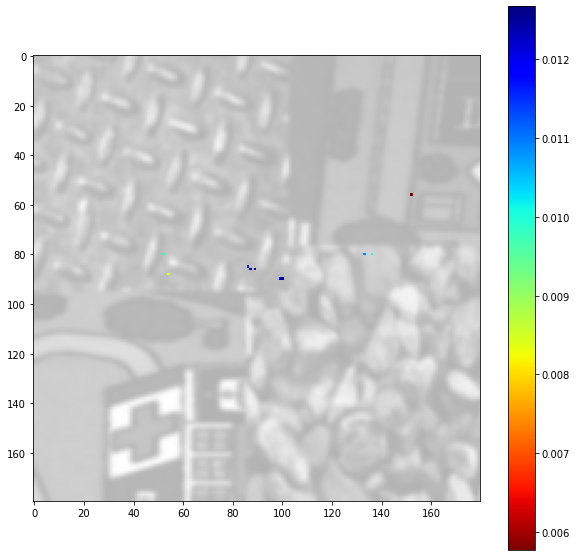

In [30]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + "data/sim/images/frame_00000022.png")
final_td = np.abs(np.ma.masked_where(final_td == 0, final_td))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [31]:
u = np.divide(1.0, final_td, where=final_td!=0.0)

id_speed = np.searchsorted(gt[:,0], start_time+duration/2)
v = np.sqrt(np.square(speed[0, id_speed]) + np.square(speed[1, id_speed]))

f = 171.377761856

C:\Users\schiavaz\AppData\Local\Temp/ipykernel_22252/2171134278.py:1: RuntimeWarning: divide by zero encountered in true_divide
  u = np.divide(1.0, final_td, where=final_td!=0.0)


In [32]:
d = td.v2depth(u, v, f)

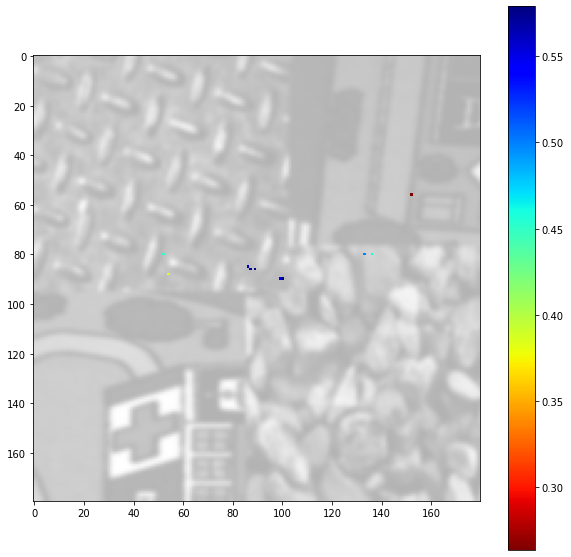

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [34]:
%matplotlib qt
vis.visualize3d(d)

In [35]:
points = vis._image2pointcloud(d)

calib = np.loadtxt(path + "/data/sim/calib.txt")
gt = np.loadtxt(path + "/data/sim/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

proj = td.project3d(points, calib, pose)

In [36]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r")
vis._set_axes_equal(ax)
plt.show()

In [37]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")
gt = np.loadtxt(path + "/data/slider-depth/groundtruth.txt")
idx = np.searchsorted(gt[:, 0], start_time)
pose = gt[idx]

In [38]:
proj = td.project3d(points, calib, pose)

In [39]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r", vmin=0.5, vmax=2.5)
ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [40]:
proj = proj[proj[:,2] < 3]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

In [41]:
o3d.visualization.draw_geometries([pcd])

In [42]:
row = 2
last_time = np.full(shape, -1.0)
td_predictions = {}
predictions = {}
px_range_pred = 7
dist = 2
final_td = np.zeros(shape)
for e in events:
#     if e[2] != row:
#         continue
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1]-dist:
        continue
    if last_time[y, x+dist] == -1:
        continue
            
    time_difference = (last_time[y, x] - last_time[y, x+dist]) / dist
    #rint(time_difference)
    
    if (y, x) in predictions:
        mean_pred = np.mean(predictions[y, x])
        mean_td_pred = np.mean(td_predictions[y, x])
        
        if np.abs(mean_pred - time_difference) > 0.1:
            continue
        #if np.abs(mean_pred - time_difference) > 0.1:
            
        if e[0] > 0.68 and len(predictions[y, x]) > 10:
            final_td[y, x] = mean_td_pred
        
        td_predictions[y, x] = []
        predictions[y, x] = []
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            y_p = y + k
            x_p = x - i
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or y_p < 0 or y_p >= shape[0]:
                continue

            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]
    

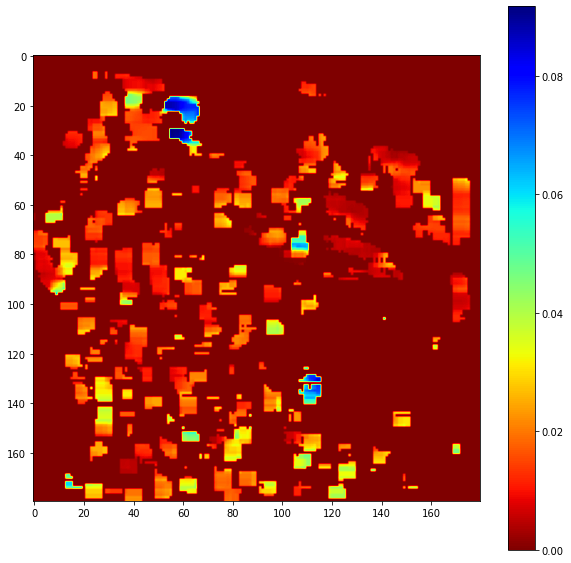

In [43]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 10)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r")
plt.colorbar(m)

In [44]:
np.rad2deg(-0.4266274931271174 - np.pi)

-204.44395478043035